In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle
import time
import os

## Generate sample data



In [73]:
# Load the data
XD = pd.read_csv('mnist_train.csv')
train_X_flat = XD.drop('label', axis=1)

# Flatten the images and scale the data
X = train_X_flat.to_numpy().reshape(-1, 28*28).astype(float)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

## PCA Components Implementation

In [89]:
# Apply PCA
n_components = 20 # Adjust the number of components as needed
pca = PCA(n_components=n_components)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

## Compute Bandwidth

In [90]:
n_samples = 20000
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=n_samples)
print("Estimated Bandwidth:", bandwidth)

Estimated Bandwidth: 616.3361269516491


## Compute clustering with MeanShift



In [91]:
# Apply MeanShift clustering
start_time_ms = time.time()

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)
end_time_ms = time.time()
elapsed_time_ms = end_time_ms - start_time_ms

labels = ms.labels_
cluster_centers = ms.cluster_centers_


 #Append cluster labels
labels_df = pd.DataFrame({'Cluster_Label': labels})
labels_file = 'cluster_labels.csv'
if os.path.exists(labels_file):
    existing_labels_df = pd.read_csv(labels_file)
    labels_df = pd.concat([existing_labels_df, labels_df], ignore_index=True)
labels_df.to_csv(labels_file, index=False)

# Append cluster centers
cluster_centers_df = pd.DataFrame(cluster_centers, columns=[f'PC_{i}' for i in range(cluster_centers.shape[1])])
cluster_centers_file = 'cluster_centers.csv'
if os.path.exists(cluster_centers_file):
    existing_cluster_centers_df = pd.read_csv(cluster_centers_file)
    cluster_centers_df = pd.concat([existing_cluster_centers_df, cluster_centers_df], ignore_index=True)
cluster_centers_df.to_csv(cluster_centers_file, index=False)

# Get the number of clusters
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
    
print("Number of Estimated Clusters:", n_clusters_)

# Save clustering model
with open('meanshift_model.pkl', 'wb') as f:
    pickle.dump(ms, f)
    
    
# Compute the Silhouette Score
silhouette_avg_loaded = silhouette_score(X_pca, labels)
print("Average Silhouette Score (Loaded):", silhouette_avg_loaded)  




Number of Estimated Clusters: 8
Average Silhouette Score (Loaded): 0.30459384870198325
Timing information saved to timing_information.csv


## Save the results

In [ ]:
timing_info_df = pd.DataFrame({
    'PCA_Components': [n_components],
    'Number_of_Samples': [n_samples],
    'Elapsed_Time_MeanShift': [elapsed_time_ms],
    'Number_of_Clusters': [n_clusters_],
    'Silhouette_Score': [silhouette_avg_loaded]
})
##
timing_info_file = 'timing_information.csv'
if os.path.exists(timing_info_file):
    existing_timing_info_df = pd.read_csv(timing_info_file)
    timing_info_df = pd.concat([existing_timing_info_df, timing_info_df], ignore_index=True)
timing_info_df.to_csv(timing_info_file, index=False)

##
timing_info_df.to_csv('timing_information.csv', index=False)

print("Timing information saved to timing_information.csv")

## Loading The Data 

In [20]:
# Load clustering model
with open('meanshift_model.pkl', 'rb') as f:
    ms_loaded = pickle.load(f)
    
# Access clustering results
labels_loaded = ms_loaded.labels_
cluster_centers_loaded = ms_loaded.cluster_centers_

# Number of clusters
labels_unique_loaded = np.unique(labels_loaded)
n_clusters_loaded = len(labels_unique_loaded)
print("Number of Estimated Clusters (Loaded):", n_clusters_loaded)

  

Number of Estimated Clusters (Loaded): 10
Average Silhouette Score (Loaded): 0.36630942675613787


## Showing the mnist data set in 2d 

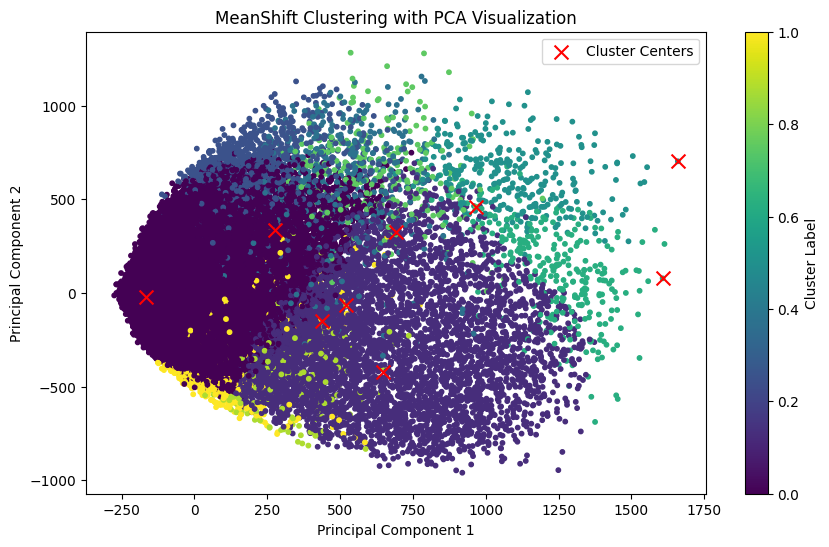

In [63]:
# Visualization (Example: 2D Visualization using PCA)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', c='red', s=100, label='Cluster Centers')
plt.title('MeanShift Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.colorbar(label='Cluster Label')
plt.show()

